<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# Deep Convolutional Generative Adversarial Networks (DCGANs)


Estimated time needed: **30** minutes

You work for an online anime video game company; the company would like to create a unique anime avatar for a game for each player. As there are millions of players, you must use a DCGANs to create each character. 


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/face_cartton.png" width="700" alt="Skills Network Logo">


## Table of Contents

<ol>
    <li><a href="https://#Objectives">Objectives</a></li>
    <li>
        <a href="https://#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-Required-Libraries">Installing Required Libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing Required Libraries</a></li>
            <li><a href="#Defining Helper Functions">Defining Helper Functions</a></li>
        </ol>       
    </li>
    <li><a href="#Introduction">Introduction</a></li>
    <li><a href="#Loading the Dataset">Loading the Dataset</a></li>
    <li><a href="#Creating Data Generator">Creating Data Generator</a></li>
    <li><a href="#Generator and Discriminator">Generator and Discriminator</a>
        <ol>
            <li><a href="#Building the Generator">Building the Generator</a></li>
            <li><a href="#Building the Discriminator">Building the Discriminator</a></li>
        </ol>  
    </li>   
    <li><a href="#Defining Loss Functions">Defining Loss Functions</a></li>
    <li><a href="#Defining Optimizers">Defining Optimizers </a></li>
    <li><a href="#Create Train Step Function">Create Train Step Function</a></li>
    <li><a href="#Training the Model">Training the Model</a>
         <ol>
            <li><a href="#Loading Pre-trained model (150 epochs)">Loading Pre-trained model (150 epochs)</a></li>
        </ol>  
    </li>     
    <li><a href="#Explore Latent Variables">Explore Latent Variables</a>
        <ol>
            <li><a href="#Exercise 1">Exercise 1</a></li>
            <li><a href="#Exercise 2">Exercise 2</a></li>
            <li><a href="#Exercise 3">Exercise 3</a></li>
        </ol>       
    </li>
</ol>



## Objectives

After completing this lab you will be able to:

*   Apply DCGANs to a dataset 
*   Understand how to train DCGANs 
*   Generate an image using a DCGAN
*   Understand how changing the input of the latent space of DCGANs changes the generated image 


## Setup


For this lab, we will be using the following libraries:

*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`Pillow`](https://pillow.readthedocs.io/en/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for image processing functions.
*   [`tensorflow`](https://www.tensorflow.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and neural network related functions.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing Required Libraries

The following required libraries are pre-installed in the Skills Network Labs environment. However, if you run this notebook command in a different Jupyter environment (like Watson Studio or Anaconda), you will need to install these libraries by removing the `#` sign before `!mamba` in the code cell below.


In [1]:
# All Libraries required for this lab are listed below. The libraries pre-installed on Skills Network Labs are commented.
#!mamba install -qy numpy==1.22.3 matplotlib==3.5.1 tensorflow==2.9.0 skillsnetwork==0.20.6

# Note: If your environment doesn't support "!mamba install", use "!pip install --user"

# RESTART YOUR KERNEL AFTERWARD AS WELL

Run the following upgrade and then **RESTART YOUR KERNEL**. Make sure the version of tensorflow imported below is **no less than 2.9.0**.


In [2]:
 %%capture
!pip3 install --upgrade tensorflow

### Importing Required Libraries

*We recommend you import all required libraries in one place (here):*


In [3]:
import warnings
warnings.simplefilter('ignore')

import keras

import numpy as np
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU


from IPython import display
import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")

import matplotlib.pyplot as plt

%matplotlib inline


import os
from os import listdir
from pathlib import Path
import imghdr

import time
from tqdm.auto import tqdm


tensorflow version: 2.11.1
skillsnetwork version: 0.20.6


### Defining Helper Functions

This function will plot five images from an array


In [4]:
def plot_array(X,title=""):
    
    plt.rcParams['figure.figsize'] = (20,20) 

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

## Introduction


In the previous lab, you learned about the working mechanics of Generative Adversarial Networks (GANs) and their various applications, such as Image Generation. However, GANs have also been known to be unstable to train, and often, the generated images suffer from being noisy and incomprehensible.

Applying Convolutional Neural Networks to GANS has led to improved results. They are called Deep Convolutional Generative Adversarial Networks (DCGANs). In this lab, we will build and train DCGANs using several approaches introduced in the original <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">DCGANs paper</a>. 


The proposed approaches are summarized here:


- Replace any pooling layers with **strided convolutions (discriminator)** and **fractional-strided
convolutions (generator)**.
- Use **batchnorm** in both the generator and the discriminator.
- **Remove fully connected hidden layers** for deeper architectures.
- Use **ReLU** activation in generator for all layers except for the output, which uses **Tanh**.
- Use **LeakyReLU** activation in the discriminator for all layers except for the output, which uses **Sigmoid**.
- Use **Adam optimizer**.  

These approaches will result in more stable training of deeper generative models.


## Loading the Dataset

We will mainly work with the Anime Face dataset from [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01). The original dataset has 63,632 "high-quality" anime faces, but to make the models train faster in this lab, we randomly sampled 20,000 images and prepared a dataset called `cartoon_20000`. 

Let's download the smaller dataset using the Skills Network library's `prepare` function:


In [5]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/cartoon_20000.zip"
await skillsnetwork.prepare(dataset_url, overwrite=True)

Extracting cartoon_20000.zip: 100%|██████████| 20001/20001 [00:10<00:00, 1914.68it/s]

Saved to '.'


The Anime Face or the Cartoon images are stored in the `cartoon_2000` folder in your current working directory. As a preprocessing step, we have removed any files that are not proper image formats (based on the file extensions) and any duplicate images.


## Creating Data Generator


First, we declare some properties of our images, including image height, image width, and batch size.


In [6]:
img_height, img_width, batch_size=64,64,128

Next, we create a Keras <code>image_dataset_from_directory</code> object with a specified image directory and the parameters are defined as above. This process may take some time:


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='cartoon_20000', # change directory to 'cartoon_data' if you use the full dataset
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)


Found 20000 files belonging to 1 classes.


The `train_ds` we defined is a `tf.data.Dataset` that yields batches of images with `image_size = (64, 64)` from the directory specified or subdirectories (if any).


**(OPTIONAL)** If you are running this notebook locally and you have multiple cores, then we can use the runtime to tune the value dynamically at runtime as follows:


In [8]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

We apply the Lambda function on `train_ds` to normalize the pixel values of all the input images from $[0, 255]$ to $[-1, 1]$:


In [9]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Let's take one batch of images for displaying:


In [10]:
images=train_ds.take(1)

Convert the batch dimension to the indexes in a list:


In [11]:
X=[x for x in images]

We can then plot the first five images in the batch using the function   ```plot_array```:


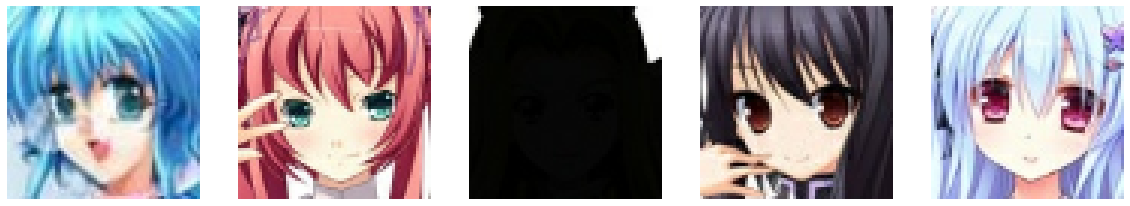

In [12]:
plot_array(X[0])

##  Generator and Discriminator


### Building the Generator


The Generator is comprised of several layers of transposed convolution, the opposite of convolution operations.

- Each Conv2DTranspose layer (except the final layer) is followed by a Batch Normalization layer and a **Relu activation**; for more implementation details, check out <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">[1]</a>. 
- The final transpose convolution layer has three output channels since the output needs to be a color image. We use the **Tanh activation** in the final layer. 

See the illustration of the architecture from <a href="https://arxiv.org/pdf/1511.06434.pdf?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">[1]</a> below.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/generator.png" alt="generator image" width="80%"></center>

We build the Generator network by using the parameter values from <a href="https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01" >[2]<a>.


In [13]:
def make_generator():
    
    model=Sequential()
    
    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))
    
    # Block 1 dimensionality of the output space  64 * 8
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (64 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (64 * 4)
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))

                       
    # Block 4: input is 16 x 16 x (64 * 2)
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, 
                              activation='tanh', name='conv_transpose_5'))

    return model

By printing the summary of the Generator architecture, we can see that the transposed convolutions **upsample** a 100-dim input vector to a high-dimensional image of size 64 x 64 x 3.


In [14]:
gen = make_generator()
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_transpose_1 (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 4, 4, 512)         2048      
                                                                 
 relu_1 (ReLU)               (None, 4, 4, 512)         0         
                                                                 
 conv_transpose_2 (Conv2DTra  (None, 8, 8, 256)        2097152   
 nspose)                                                         
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)         1024      
                                                                 
 relu_2 (ReLU)               (None, 8, 8, 256)         0

### Building the Discriminator


The Discriminator has five convolution layers. 

- All but the first and final Conv2D layers have Batch Normalization, since directly applying batchnorm to all layers could result in sample oscillation and model instability; 
- The first four Conv2D layers use the **Leaky-Relu activation** with a slope of 0.2. 
- Lastly, instead of a fully connected layer, the  output layer has a convolution layer with a **Sigmoid activation** function.


In [15]:
def make_discriminator():
    
    model=Sequential()
    
    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,  
                     activation='sigmoid', name='conv_5'))

    return model 

By printing the summary of the Discriminator architecture, we can see that the strided convolutions **downsample** an input image of size 64 x 64 x 3.


In [16]:
disc = make_discriminator()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 128)       131072    
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 128)       512       
                                                                 
 leaky_relu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 256)         524288    
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)        

## Defining Loss Functions

As we discussed in the previous lab, the min-max optimization problem can be formulated by minimizing the cross entropy loss for the Generator and Discriminator.  

The `cross_entropy` object is the Binary Cross Entropy loss that will be used to model the objectives of the two networks.


In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [19]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

## Defining Optimizers 
 
We create two Adam optimizers for the discriminator and the generator, respectively. We pass the following arguments to the optimizers:

- learning rate of 0.0002.
- beta coefficients $\beta_1 = 0.5$ and $\beta_2 = 0.999$, which are responsible for computing the running averages of the gradients during backpropagation.


In [20]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

## Create Train Step Function

As this lab is more computationally intensive than the last lab, we convert the training step into a function and then use the  @tf.function decorator, which allows the function to be "compiled" into a **callable TensorFlow graph**. This will speed up the training; for more information, read <a href="https://www.tensorflow.org/guide/function?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01">here </a> 


In [21]:
@tf.function

def train_step(X):
    
    #random samples it was found if you increase the  stander deviation, you get better results 
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample 
        xhat = generator(z, training=True)
        #the output of the discriminator for real data 
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)
        
        #loss for each 
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Don't be intimidated by the code above, here is a summary of what a train step accomplishes:

- First, we sample `z`, a batch of noise vectors from a normal distribution ($\mu = 1, \sigma = 1$) and feed it to the Generator.
- The Generator produces generated or "fake" images `xhat`.
- We feed real images `X` and fake images `xhat` to the Discriminator and obtain `real_output` and `fake_output` respectively as the scores.
- We calculate Generator loss `gen_loss` using the `fake_output` from Discriminator since we want the fake images to fool the Discriminator as much as possible.
- We calculate Discriminator loss `disc_loss` using both the `real_output` and `fake_output` since we want the Discriminator to distinguish the two as much as possible.
- We calculate `gradients_of_generator` and  `gradients_of_discriminator` based on the losses obtained.
- Finally, we update the Generator and Discriminator by letting their respective optimizers apply the processed gradients on the trainable model parameters.


We can transform the random noise using the generator. As the generator is not trained yet, the output appears to be noises:


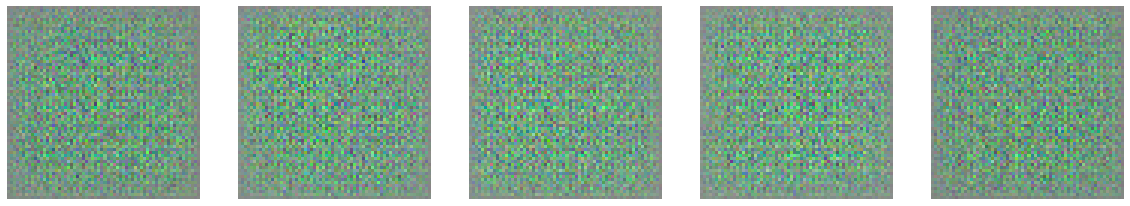

In [22]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

## Training the Model


As this method is computationally intensive, we will train the model for one epoch and then use the generator to produce artificial images.


epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1, iteration 1


epoch 1:   1%|          | 1/157 [00:09<24:43,  9.51s/it]

epoch 1, iteration 2


epoch 1:   1%|▏         | 2/157 [00:12<19:29,  7.54s/it]

epoch 1, iteration 3


epoch 1:   2%|▏         | 3/157 [00:15<15:59,  6.23s/it]

epoch 1, iteration 4


epoch 1:   3%|▎         | 4/157 [00:18<13:34,  5.33s/it]

epoch 1, iteration 5


epoch 1:   3%|▎         | 5/157 [00:21<11:46,  4.65s/it]

epoch 1, iteration 6


epoch 1:   4%|▍         | 6/157 [00:24<10:28,  4.16s/it]

epoch 1, iteration 7


epoch 1:   4%|▍         | 7/157 [00:28<09:35,  3.84s/it]

epoch 1, iteration 8


epoch 1:   5%|▌         | 8/157 [00:31<08:56,  3.60s/it]

epoch 1, iteration 9


epoch 1:   6%|▌         | 9/157 [00:34<08:28,  3.44s/it]

epoch 1, iteration 10


epoch 1:   6%|▋         | 10/157 [00:37<08:08,  3.32s/it]

epoch 1, iteration 11


epoch 1:   7%|▋         | 11/157 [00:40<07:54,  3.25s/it]

epoch 1, iteration 12


epoch 1:   8%|▊         | 12/157 [00:43<07:39,  3.17s/it]

epoch 1, iteration 13


epoch 1:   8%|▊         | 13/157 [00:46<07:32,  3.14s/it]

epoch 1, iteration 14


epoch 1:   9%|▉         | 14/157 [00:49<07:32,  3.17s/it]

epoch 1, iteration 15


epoch 1:  10%|▉         | 15/157 [00:52<07:19,  3.10s/it]

epoch 1, iteration 16


epoch 1:  10%|█         | 16/157 [00:55<07:17,  3.10s/it]

epoch 1, iteration 17


epoch 1:  11%|█         | 17/157 [00:58<07:09,  3.07s/it]

epoch 1, iteration 18


epoch 1:  11%|█▏        | 18/157 [01:01<07:08,  3.08s/it]

epoch 1, iteration 19


epoch 1:  12%|█▏        | 19/157 [01:04<07:09,  3.11s/it]

epoch 1, iteration 20


epoch 1:  13%|█▎        | 20/157 [01:07<07:02,  3.08s/it]

epoch 1, iteration 21


epoch 1:  13%|█▎        | 21/157 [01:10<06:59,  3.09s/it]

epoch 1, iteration 22


epoch 1:  14%|█▍        | 22/157 [01:14<06:55,  3.08s/it]

epoch 1, iteration 23


epoch 1:  15%|█▍        | 23/157 [01:17<06:50,  3.06s/it]

epoch 1, iteration 24


epoch 1:  15%|█▌        | 24/157 [01:20<06:50,  3.09s/it]

epoch 1, iteration 25


epoch 1:  16%|█▌        | 25/157 [01:23<06:51,  3.12s/it]

epoch 1, iteration 26


epoch 1:  17%|█▋        | 26/157 [01:26<06:49,  3.13s/it]

epoch 1, iteration 27


epoch 1:  17%|█▋        | 27/157 [01:29<06:40,  3.08s/it]

epoch 1, iteration 28


epoch 1:  18%|█▊        | 28/157 [01:32<06:40,  3.10s/it]

epoch 1, iteration 29


epoch 1:  18%|█▊        | 29/157 [01:35<06:35,  3.09s/it]

epoch 1, iteration 30


epoch 1:  19%|█▉        | 30/157 [01:38<06:29,  3.07s/it]

epoch 1, iteration 31


epoch 1:  20%|█▉        | 31/157 [01:41<06:31,  3.10s/it]

epoch 1, iteration 32


epoch 1:  20%|██        | 32/157 [01:45<06:30,  3.12s/it]

epoch 1, iteration 33


epoch 1:  21%|██        | 33/157 [01:48<06:21,  3.08s/it]

epoch 1, iteration 34


epoch 1:  22%|██▏       | 34/157 [01:51<06:22,  3.11s/it]

epoch 1, iteration 35


epoch 1:  22%|██▏       | 35/157 [01:54<06:18,  3.11s/it]

epoch 1, iteration 36


epoch 1:  23%|██▎       | 36/157 [01:57<06:10,  3.06s/it]

epoch 1, iteration 37


epoch 1:  24%|██▎       | 37/157 [02:01<06:47,  3.39s/it]

epoch 1, iteration 38


epoch 1:  24%|██▍       | 38/157 [02:05<07:08,  3.60s/it]

epoch 1, iteration 39


epoch 1:  25%|██▍       | 39/157 [02:09<07:23,  3.75s/it]

epoch 1, iteration 40


epoch 1:  25%|██▌       | 40/157 [02:13<07:15,  3.72s/it]

epoch 1, iteration 41


epoch 1:  26%|██▌       | 41/157 [02:17<07:17,  3.77s/it]

epoch 1, iteration 42


epoch 1:  27%|██▋       | 42/157 [02:21<07:14,  3.78s/it]

epoch 1, iteration 43


epoch 1:  27%|██▋       | 43/157 [02:24<06:55,  3.65s/it]

epoch 1, iteration 44


epoch 1:  28%|██▊       | 44/157 [02:27<06:49,  3.62s/it]

epoch 1, iteration 45


epoch 1:  29%|██▊       | 45/157 [02:31<06:42,  3.59s/it]

epoch 1, iteration 46


epoch 1:  29%|██▉       | 46/157 [02:34<06:24,  3.47s/it]

epoch 1, iteration 47


epoch 1:  30%|██▉       | 47/157 [02:37<05:57,  3.25s/it]

epoch 1, iteration 48


epoch 1:  31%|███       | 48/157 [02:40<05:47,  3.18s/it]

epoch 1, iteration 49


epoch 1:  31%|███       | 49/157 [02:43<05:42,  3.17s/it]

epoch 1, iteration 50


epoch 1:  32%|███▏      | 50/157 [02:46<05:47,  3.24s/it]

epoch 1, iteration 51


epoch 1:  32%|███▏      | 51/157 [02:50<05:42,  3.23s/it]

epoch 1, iteration 52


epoch 1:  33%|███▎      | 52/157 [02:53<05:36,  3.21s/it]

epoch 1, iteration 53


epoch 1:  34%|███▍      | 53/157 [02:56<05:30,  3.18s/it]

epoch 1, iteration 54


epoch 1:  34%|███▍      | 54/157 [02:59<05:19,  3.11s/it]

epoch 1, iteration 55


epoch 1:  35%|███▌      | 55/157 [03:02<05:18,  3.12s/it]

epoch 1, iteration 56


epoch 1:  36%|███▌      | 56/157 [03:05<05:09,  3.07s/it]

epoch 1, iteration 57


epoch 1:  36%|███▋      | 57/157 [03:09<05:50,  3.51s/it]

epoch 1, iteration 58


epoch 1:  37%|███▋      | 58/157 [03:13<05:32,  3.36s/it]

epoch 1, iteration 59


epoch 1:  38%|███▊      | 59/157 [03:15<05:16,  3.23s/it]

epoch 1, iteration 60


epoch 1:  38%|███▊      | 60/157 [03:18<05:08,  3.18s/it]

epoch 1, iteration 61


epoch 1:  39%|███▉      | 61/157 [03:21<04:57,  3.10s/it]

epoch 1, iteration 62


epoch 1:  39%|███▉      | 62/157 [03:25<05:04,  3.20s/it]

epoch 1, iteration 63


epoch 1:  40%|████      | 63/157 [03:28<04:58,  3.18s/it]

epoch 1, iteration 64


epoch 1:  41%|████      | 64/157 [03:31<04:51,  3.13s/it]

epoch 1, iteration 65


epoch 1:  41%|████▏     | 65/157 [03:34<04:46,  3.12s/it]

epoch 1, iteration 66


epoch 1:  42%|████▏     | 66/157 [03:38<04:53,  3.23s/it]

epoch 1, iteration 67


epoch 1:  43%|████▎     | 67/157 [03:41<04:59,  3.33s/it]

epoch 1, iteration 68


epoch 1:  43%|████▎     | 68/157 [03:45<04:58,  3.36s/it]

epoch 1, iteration 69


epoch 1:  44%|████▍     | 69/157 [03:48<04:54,  3.35s/it]

epoch 1, iteration 70


epoch 1:  45%|████▍     | 70/157 [03:51<04:55,  3.39s/it]

epoch 1, iteration 71


epoch 1:  45%|████▌     | 71/157 [03:55<05:00,  3.49s/it]

epoch 1, iteration 72


epoch 1:  46%|████▌     | 72/157 [03:58<04:51,  3.43s/it]

epoch 1, iteration 73


epoch 1:  46%|████▋     | 73/157 [04:02<04:46,  3.41s/it]

epoch 1, iteration 74


epoch 1:  47%|████▋     | 74/157 [04:05<04:43,  3.42s/it]

epoch 1, iteration 75


epoch 1:  48%|████▊     | 75/157 [04:09<04:42,  3.44s/it]

epoch 1, iteration 76


epoch 1:  48%|████▊     | 76/157 [04:12<04:35,  3.40s/it]

epoch 1, iteration 77


epoch 1:  49%|████▉     | 77/157 [04:15<04:29,  3.37s/it]

epoch 1, iteration 78


epoch 1:  50%|████▉     | 78/157 [04:19<04:25,  3.36s/it]

epoch 1, iteration 79


epoch 1:  50%|█████     | 79/157 [04:22<04:18,  3.31s/it]

epoch 1, iteration 80


epoch 1:  51%|█████     | 80/157 [04:25<04:13,  3.29s/it]

epoch 1, iteration 81


epoch 1:  52%|█████▏    | 81/157 [04:28<04:05,  3.23s/it]

epoch 1, iteration 82


epoch 1:  52%|█████▏    | 82/157 [04:31<04:00,  3.21s/it]

epoch 1, iteration 83


epoch 1:  53%|█████▎    | 83/157 [04:35<03:57,  3.21s/it]

epoch 1, iteration 84


epoch 1:  54%|█████▎    | 84/157 [04:38<03:54,  3.21s/it]

epoch 1, iteration 85


epoch 1:  54%|█████▍    | 85/157 [04:41<03:52,  3.22s/it]

epoch 1, iteration 86


epoch 1:  55%|█████▍    | 86/157 [04:44<03:48,  3.22s/it]

epoch 1, iteration 87


epoch 1:  55%|█████▌    | 87/157 [04:47<03:45,  3.22s/it]

epoch 1, iteration 88


epoch 1:  56%|█████▌    | 88/157 [04:51<03:41,  3.22s/it]

epoch 1, iteration 89


epoch 1:  57%|█████▋    | 89/157 [04:54<03:39,  3.22s/it]

epoch 1, iteration 90


epoch 1:  57%|█████▋    | 90/157 [04:57<03:30,  3.14s/it]

epoch 1, iteration 91


epoch 1:  58%|█████▊    | 91/157 [05:00<03:27,  3.15s/it]

epoch 1, iteration 92


epoch 1:  59%|█████▊    | 92/157 [05:03<03:24,  3.15s/it]

epoch 1, iteration 93


epoch 1:  59%|█████▉    | 93/157 [05:06<03:18,  3.10s/it]

epoch 1, iteration 94


epoch 1:  60%|█████▉    | 94/157 [05:09<03:17,  3.14s/it]

epoch 1, iteration 95


epoch 1:  61%|██████    | 95/157 [05:13<03:18,  3.20s/it]

epoch 1, iteration 96


epoch 1:  61%|██████    | 96/157 [05:16<03:15,  3.21s/it]

epoch 1, iteration 97


epoch 1:  62%|██████▏   | 97/157 [05:19<03:08,  3.14s/it]

epoch 1, iteration 98


epoch 1:  62%|██████▏   | 98/157 [05:22<03:04,  3.12s/it]

epoch 1, iteration 99


epoch 1:  63%|██████▎   | 99/157 [05:25<03:00,  3.12s/it]

epoch 1, iteration 100


epoch 1:  64%|██████▎   | 100/157 [05:28<02:56,  3.10s/it]

epoch 1, iteration 101


epoch 1:  64%|██████▍   | 101/157 [05:32<02:59,  3.20s/it]

epoch 1, iteration 102


epoch 1:  65%|██████▍   | 102/157 [05:35<02:52,  3.14s/it]

epoch 1, iteration 103


epoch 1:  66%|██████▌   | 103/157 [05:38<02:47,  3.10s/it]

epoch 1, iteration 104


epoch 1:  66%|██████▌   | 104/157 [05:41<02:41,  3.05s/it]

epoch 1, iteration 105


epoch 1:  67%|██████▋   | 105/157 [05:43<02:37,  3.02s/it]

epoch 1, iteration 106


epoch 1:  68%|██████▊   | 106/157 [05:46<02:34,  3.02s/it]

epoch 1, iteration 107


epoch 1:  68%|██████▊   | 107/157 [05:50<02:30,  3.02s/it]

epoch 1, iteration 108


epoch 1:  69%|██████▉   | 108/157 [05:52<02:26,  2.99s/it]

epoch 1, iteration 109


epoch 1:  69%|██████▉   | 109/157 [05:56<02:28,  3.08s/it]

epoch 1, iteration 110


epoch 1:  70%|███████   | 110/157 [05:59<02:27,  3.15s/it]

epoch 1, iteration 111


epoch 1:  71%|███████   | 111/157 [06:03<02:33,  3.33s/it]

epoch 1, iteration 112


epoch 1:  71%|███████▏  | 112/157 [06:06<02:34,  3.43s/it]

epoch 1, iteration 113


epoch 1:  72%|███████▏  | 113/157 [06:10<02:29,  3.39s/it]

epoch 1, iteration 114


epoch 1:  73%|███████▎  | 114/157 [06:13<02:19,  3.24s/it]

epoch 1, iteration 115


epoch 1:  73%|███████▎  | 115/157 [06:16<02:21,  3.37s/it]

epoch 1, iteration 116


epoch 1:  74%|███████▍  | 116/157 [06:22<02:43,  3.98s/it]

epoch 1, iteration 117


epoch 1:  75%|███████▍  | 117/157 [06:26<02:41,  4.04s/it]

epoch 1, iteration 118


epoch 1:  75%|███████▌  | 118/157 [06:29<02:25,  3.72s/it]

epoch 1, iteration 119


epoch 1:  76%|███████▌  | 119/157 [06:32<02:11,  3.46s/it]

epoch 1, iteration 120


epoch 1:  76%|███████▋  | 120/157 [06:34<01:58,  3.20s/it]

epoch 1, iteration 121


epoch 1:  77%|███████▋  | 121/157 [06:37<01:48,  3.01s/it]

epoch 1, iteration 122


epoch 1:  78%|███████▊  | 122/157 [06:40<01:45,  3.01s/it]

epoch 1, iteration 123


epoch 1:  78%|███████▊  | 123/157 [06:43<01:40,  2.97s/it]

epoch 1, iteration 124


epoch 1:  79%|███████▉  | 124/157 [06:46<01:38,  2.98s/it]

epoch 1, iteration 125


epoch 1:  80%|███████▉  | 125/157 [06:49<01:35,  3.00s/it]

epoch 1, iteration 126


epoch 1:  80%|████████  | 126/157 [06:52<01:32,  2.99s/it]

epoch 1, iteration 127


epoch 1:  81%|████████  | 127/157 [06:55<01:31,  3.04s/it]

epoch 1, iteration 128


epoch 1:  82%|████████▏ | 128/157 [06:58<01:27,  3.01s/it]

epoch 1, iteration 129


epoch 1:  82%|████████▏ | 129/157 [07:01<01:23,  2.98s/it]

epoch 1, iteration 130


epoch 1:  83%|████████▎ | 130/157 [07:04<01:20,  2.97s/it]

epoch 1, iteration 131


epoch 1:  83%|████████▎ | 131/157 [07:07<01:16,  2.95s/it]

epoch 1, iteration 132


epoch 1:  84%|████████▍ | 132/157 [07:10<01:16,  3.07s/it]

epoch 1, iteration 133


epoch 1:  85%|████████▍ | 133/157 [07:13<01:15,  3.13s/it]

epoch 1, iteration 134


epoch 1:  85%|████████▌ | 134/157 [07:16<01:12,  3.14s/it]

epoch 1, iteration 135


epoch 1:  86%|████████▌ | 135/157 [07:20<01:09,  3.15s/it]

epoch 1, iteration 136


epoch 1:  87%|████████▋ | 136/157 [07:23<01:05,  3.13s/it]

epoch 1, iteration 137


epoch 1:  87%|████████▋ | 137/157 [07:26<01:02,  3.11s/it]

epoch 1, iteration 138


epoch 1:  88%|████████▊ | 138/157 [07:29<01:00,  3.18s/it]

epoch 1, iteration 139


epoch 1:  89%|████████▊ | 139/157 [07:33<00:58,  3.27s/it]

epoch 1, iteration 140


epoch 1:  89%|████████▉ | 140/157 [07:36<00:54,  3.18s/it]

epoch 1, iteration 141


epoch 1:  90%|████████▉ | 141/157 [07:39<00:49,  3.12s/it]

epoch 1, iteration 142


epoch 1:  90%|█████████ | 142/157 [07:41<00:46,  3.08s/it]

epoch 1, iteration 143


epoch 1:  91%|█████████ | 143/157 [07:45<00:43,  3.08s/it]

epoch 1, iteration 144


epoch 1:  92%|█████████▏| 144/157 [07:47<00:39,  3.01s/it]

epoch 1, iteration 145


epoch 1:  92%|█████████▏| 145/157 [07:52<00:40,  3.35s/it]

epoch 1, iteration 146


epoch 1:  93%|█████████▎| 146/157 [07:56<00:39,  3.60s/it]

epoch 1, iteration 147


epoch 1:  94%|█████████▎| 147/157 [08:00<00:36,  3.68s/it]

epoch 1, iteration 148


epoch 1:  94%|█████████▍| 148/157 [08:03<00:31,  3.45s/it]

epoch 1, iteration 149


epoch 1:  95%|█████████▍| 149/157 [08:06<00:26,  3.34s/it]

epoch 1, iteration 150


epoch 1:  96%|█████████▌| 150/157 [08:09<00:23,  3.29s/it]

epoch 1, iteration 151


epoch 1:  96%|█████████▌| 151/157 [08:12<00:19,  3.18s/it]

epoch 1, iteration 152


epoch 1:  97%|█████████▋| 152/157 [08:15<00:15,  3.14s/it]

epoch 1, iteration 153


epoch 1:  97%|█████████▋| 153/157 [08:18<00:12,  3.16s/it]

epoch 1, iteration 154


epoch 1:  98%|█████████▊| 154/157 [08:21<00:09,  3.20s/it]

epoch 1, iteration 155


epoch 1:  99%|█████████▊| 155/157 [08:24<00:06,  3.16s/it]

epoch 1, iteration 156


epoch 1:  99%|█████████▉| 156/157 [08:27<00:03,  3.13s/it]

epoch 1, iteration 157


epoch 1: 100%|██████████| 157/157 [08:34<00:00,  3.28s/it]


orignal images


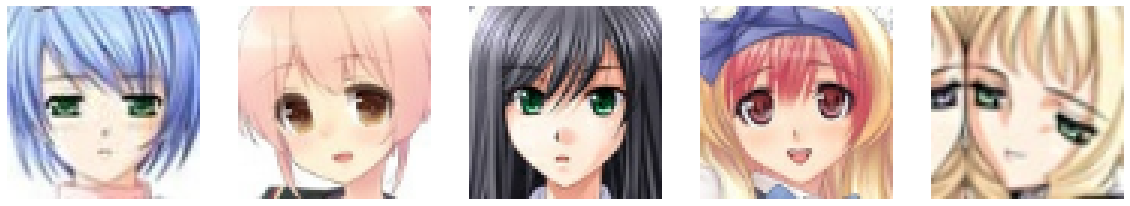

generated images


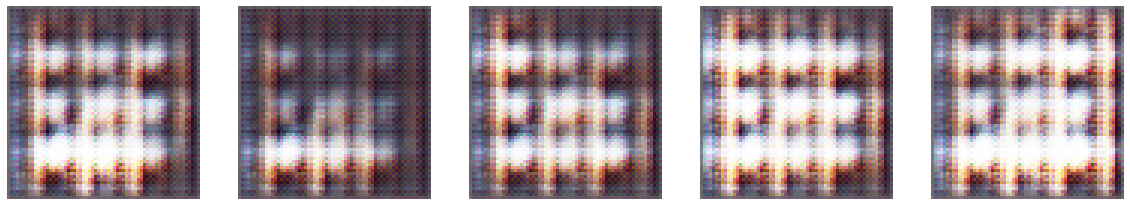

Time for epoch 1 is 519.5909450054169 sec


In [23]:
epochs=1

discriminator=make_discriminator()

generator= make_generator()


for epoch in range(epochs):
    
    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):
        
        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))
            
        train_step(X)
    

    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

As you can see that, with only one epoch of training and a reduced number of training images, our GAN didn't learn much information, and thus, the generator wasn't able to produce images that make sense to human eyes. There are two quick actions you can take to try to improve the results:

1. Re-train the GAN using the full dataset that has 63,632 images. 
    - To do so, simply go back to the **Loading the Dataset** section, replace the url of the dataset with "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module5/L2/cartoon_data.tgz", change the `directory` argument in `tf.keras.utils.image_dataset_from_directory` to `'cartoon_data'` and re-run all the cells. 
    - Note that using more training data does allows the model to learn better and perform better, but it will result in longer training time! **With 63K training images and batch size of 128, your model will train for ~497 iterations.**


2. Use a pre-trained generator model to generate images.
    - You don't need to experience the training time at all! 
    - Proceed to the next subsection to load a pre-trained model, and you will see that the generator trained with 150 epochs can produce almost realistic anime faces.


### Loading Pre-trained model (150 epochs)


As you saw, training a GAN with only one epoch takes quite a long time. If we want to evaluate the performance of a fully trained and optimized GAN, we would need to increase the number of epochs. Thus, to help you avoid extremely long training time in this lab, we will just download the pre-trained Generator network parameters and then use Kera `load_model` function to obtain a pre-trained Generator, which we will use to generate images directly.


In [24]:
generator_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/generator.tar.gz"
await skillsnetwork.prepare(generator_url, overwrite=True)

Extracting generator.tar.gz: 100%|██████████| 7/7 [00:00<00:00, 32.84it/s]

Saved to '.'


Load the generator:


In [25]:
from tensorflow.keras.models import load_model


full_generator=load_model("generator")

Let's generate several images using the fully trained Generator and display them:


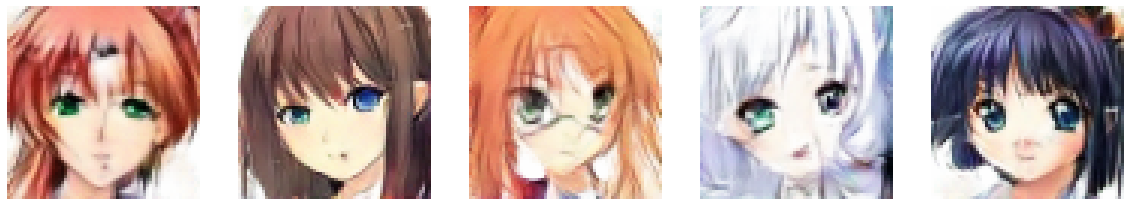

In [26]:
latent_dim=100

# input consists of noise vectors
noise = tf.random.normal([200, 1, 1, latent_dim])

# feed the noise vectors to the generator
Xhat=full_generator(noise,training=False)
plot_array(Xhat)

## Explore Latent Variables 
Values of $\mathbf{z}$ that are relatively close together will produce similar images. For example, we can assigns elements of $\mathbf{z}$ close values such as $[1,0.8,..,0.4]$. 


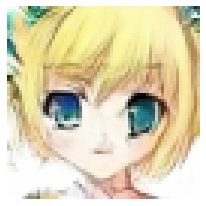

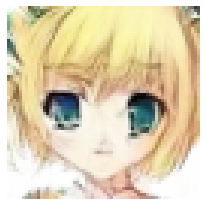

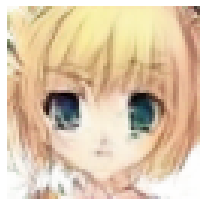

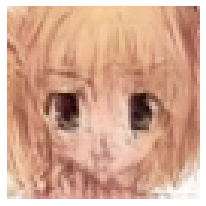

In [27]:
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(c*tf.ones([1, 1, 1, latent_dim]),training=False) # latent_dim = 100 defined previously
    plot_array(Xhat)

### Exercise 1

Plot the generated images by the Generator with elements of $\mathbf{z}$ equal $[-1,-0.8,-0.6,-0.4]$. 


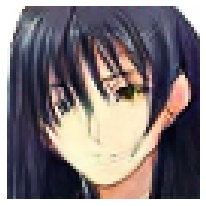

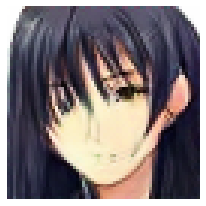

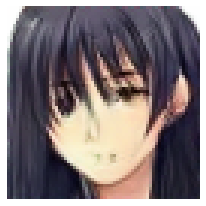

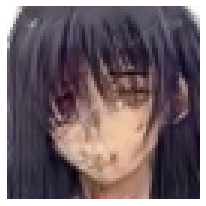

In [33]:
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(-c*tf.ones([1, 1, 1, latent_dim]),training=False)
    plot_array(Xhat)

<details>
    <summary>Click here for Solution</summary>

```python
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(-c*tf.ones([1, 1, 1, latent_dim]),training=False)
    plot_array(Xhat)
 ```   

</details>


We can see how changing the latent variable changes the generated image. Here we alter more and more subsequent values of $\mathbf{z}$ from 1 to -1; we see the images change accordingly; this is evident in the anime character's hair color:


elements from 0 to 0 is set to -1


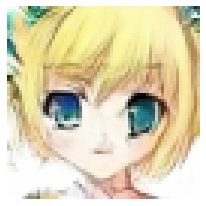

elements from 0 to 10 is set to -1


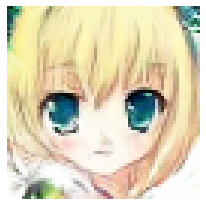

elements from 0 to 20 is set to -1


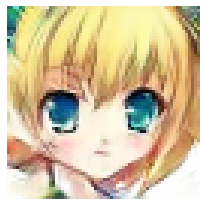

elements from 0 to 30 is set to -1


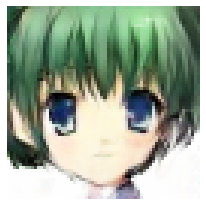

elements from 0 to 40 is set to -1


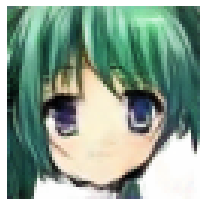

elements from 0 to 50 is set to -1


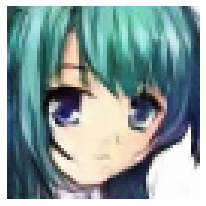

elements from 0 to 60 is set to -1


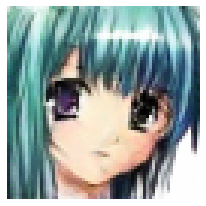

elements from 0 to 70 is set to -1


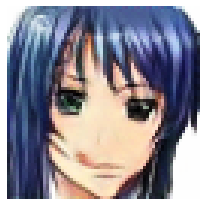

elements from 0 to 80 is set to -1


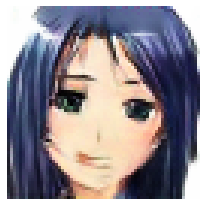

elements from 0 to 90 is set to -1


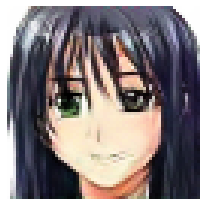

In [34]:
z=np.ones( (1, 1, 1, latent_dim))
for n in range(10):

    z[0, 0, 0, 0:10*n]=-1

    Xhat=full_generator(z,training=False)
    print("elements from 0 to {} is set to -1".format(10*n))
    plot_array(Xhat)

### Exercise 2

Repeat the above procedure but set the latent variable $z[0, 0, 0, 0:20*n] = -0.5*n$ each time `for n in range(5)`


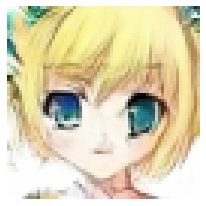

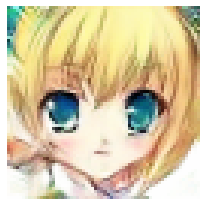

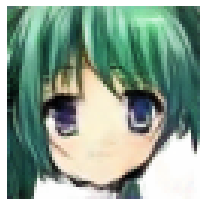

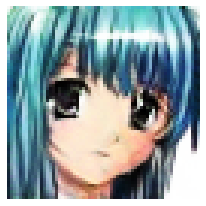

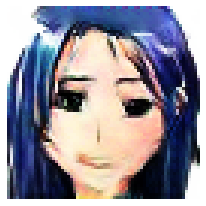

In [35]:
z=np.ones( (1, 1, 1, latent_dim))
for n in range(5):

    z[0, 0, 0, 0:20*n]=-0.5*n

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)

<details>
    <summary>Click here for Solution</summary>

```python
z=np.ones( (1, 1, 1, latent_dim))
for n in range(5):

    z[0, 0, 0, 0:20*n]=-0.5*n

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)
    

 ```   

</details>


We can also hold some of the elements of $\mathbf{z}$ constant and randomly change others. Here, we set the first 20 elements to one and randomly change the rest. We see that all through the images change, the hair color remains light. 


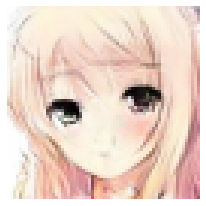

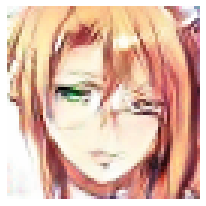

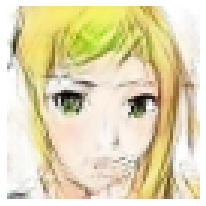

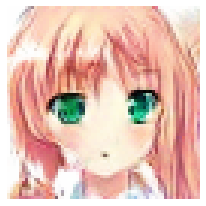

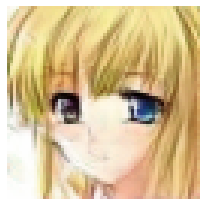

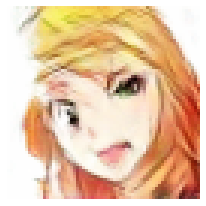

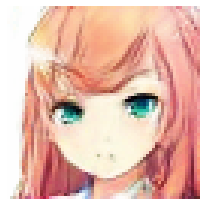

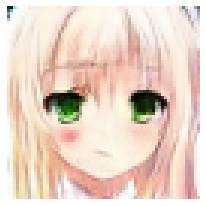

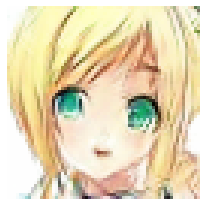

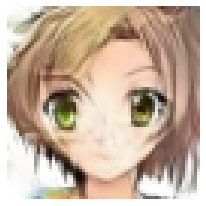

In [36]:
for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)

### Exercise 3

Repeat the procedure above, but set the elements of $\mathbf{z}$ from index 0 to 35 to -1


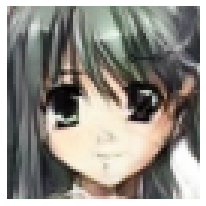

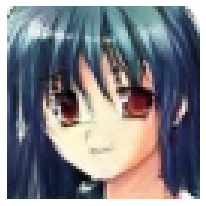

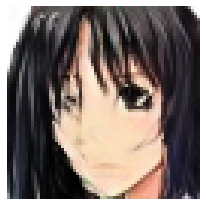

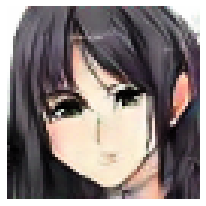

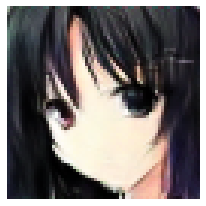

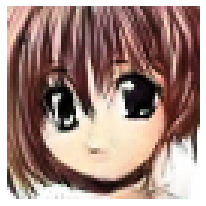

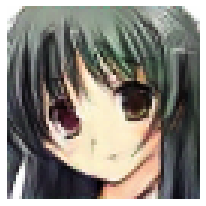

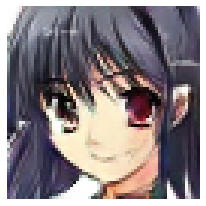

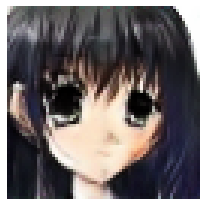

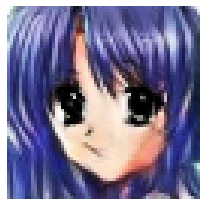

In [37]:
for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=-1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)
    

<details>
    <summary>Click here for Solution</summary>

```python

for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=-1

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)
    

 ```   

</details>


## Authors


<a href="https://www.linkedin.com/in/joseph-s-50398b136/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01" target="_blank">Joseph Santarcangelo</a>

[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) is a Data Science intern at IBM Skills Network, entering level-5 study in the Mathematics & Statistics undergraduate Coop program at McMaster University.


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By  | Change Description |
| ----------------- | ------- | ----------- | ------------------ |
| 2022-08-30        | 0.1     | Joseph Santarcangelo  | Created Lab       |
| 2022-09-06        | 0.1     | Roxanne Li  | Reviewed and edited Lab       |
| 2022-09-23        | 0.1     | Steve Hord  | QA pass edits                 |


Copyright © 2022 IBM Corporation. All rights reserved.
